# Lab Solution: Early Stopping and Training Monitoring

## Introduction

You've recently joined HealthTech Analytics, a healthcare AI startup that's developing systems to predict patient readmission risk based on electronic health records. As a junior data scientist, you've been tasked with implementing a neural network model, which has been showing promising results but has inconsistent performance.

Your manager explains that the model sometimes performs well, but other times it overfits to training data or fails to converge properly. She suspects that proper training monitoring and early stopping strategies might solve these issues, making the model more reliable for clinical applications.

The Chief Data Officer has emphasized that the company can't afford to waste computational resources on models that aren't learning effectively, and clinical staff need stable, reliable predictions. You'll need to implement proper training monitoring and callbacks to ensure the model trains efficiently and generalizes well to new patient data.

## Part 0: Import Libraries and Set Up Environment

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set random seeds for reproducibility
import random
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-05-23 19:38:47.763038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Part 1: Load and Explore Dataset

The dataset contains information from diabetic patients with various features such as age, gender, lab results, medical history, and a target variable indicating whether the patient was readmitted within 30 days, after 30 days, or not at all.

In [2]:
# Load in Data
patient_data = pd.read_csv('readmission_data.csv')
patient_data.info()
patient_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Dataset shape: (101766, 50)
Readmission rate: readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Readmissions')

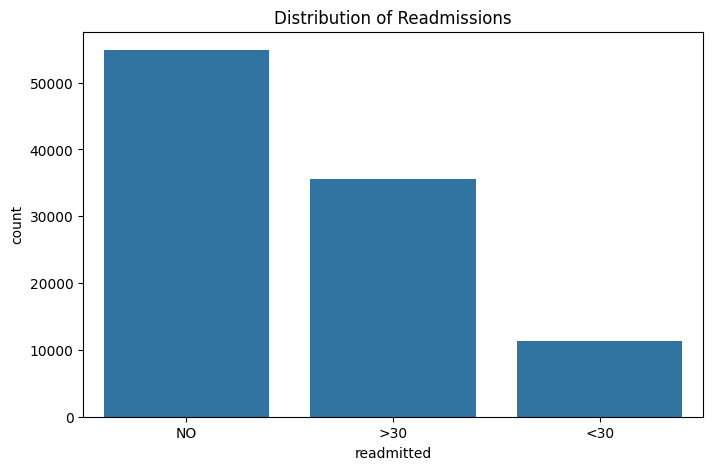

In [3]:
# Let's explore the dataset
print(f"Dataset shape: {patient_data.shape}")
print(f"Readmission rate: {patient_data['readmitted'].value_counts(normalize=True)}")

# Check class balance
plt.figure(figsize=(8, 5))
sns.countplot(x='readmitted', data=patient_data)
plt.title('Distribution of Readmissions')

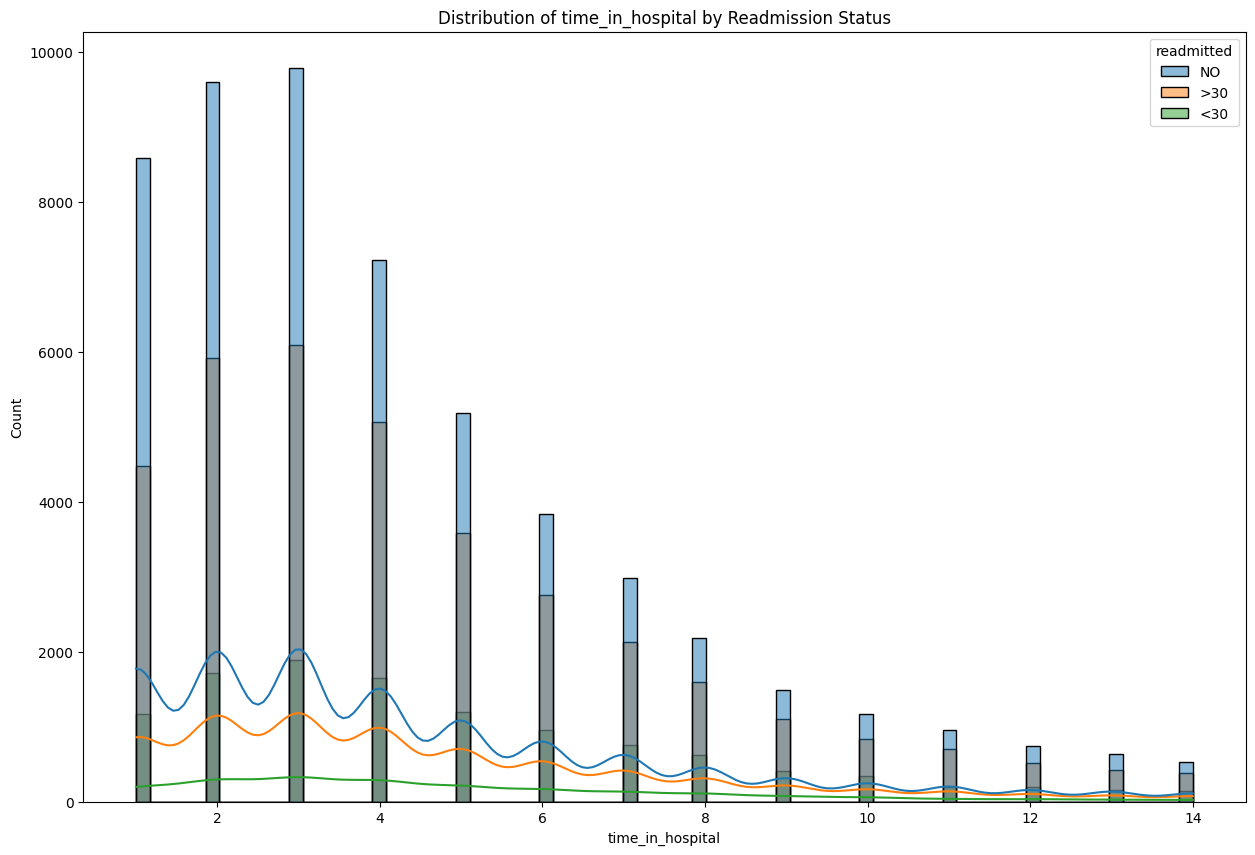

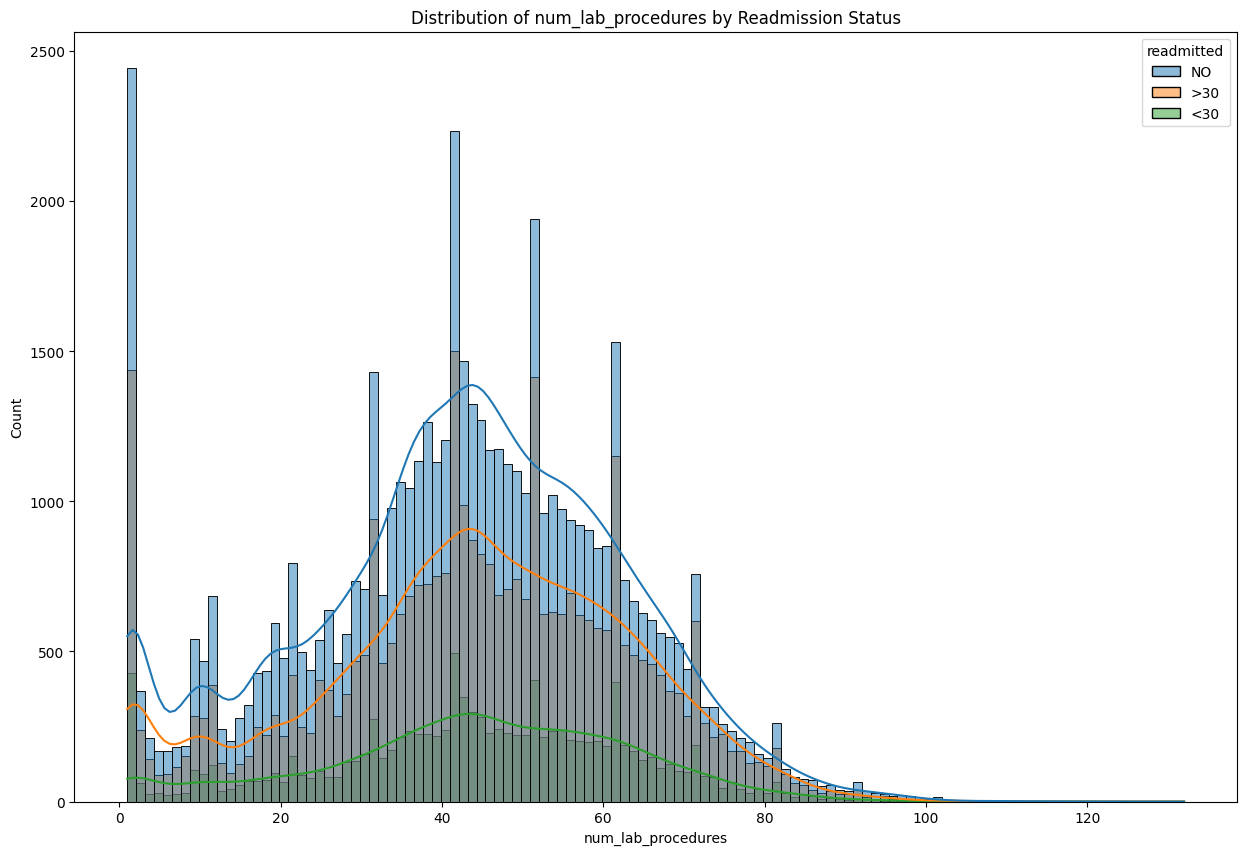

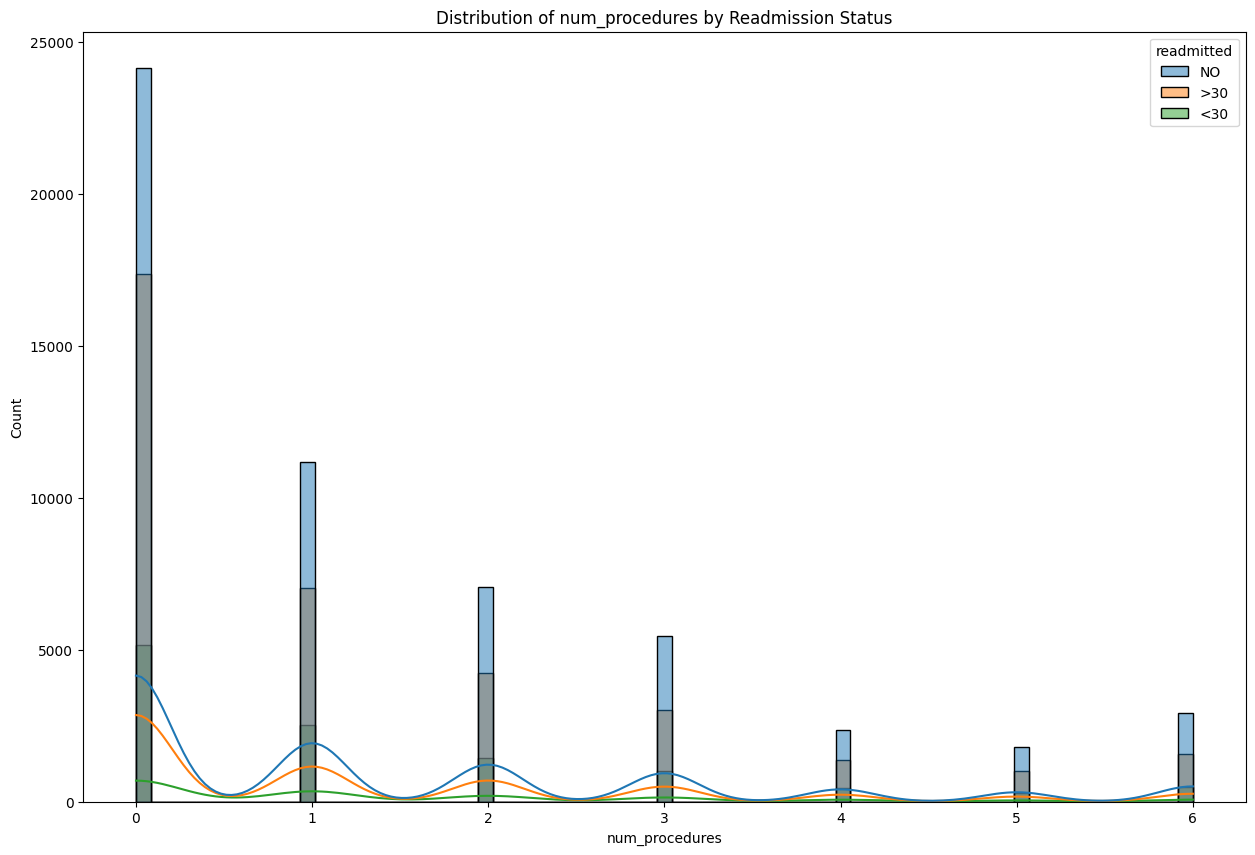

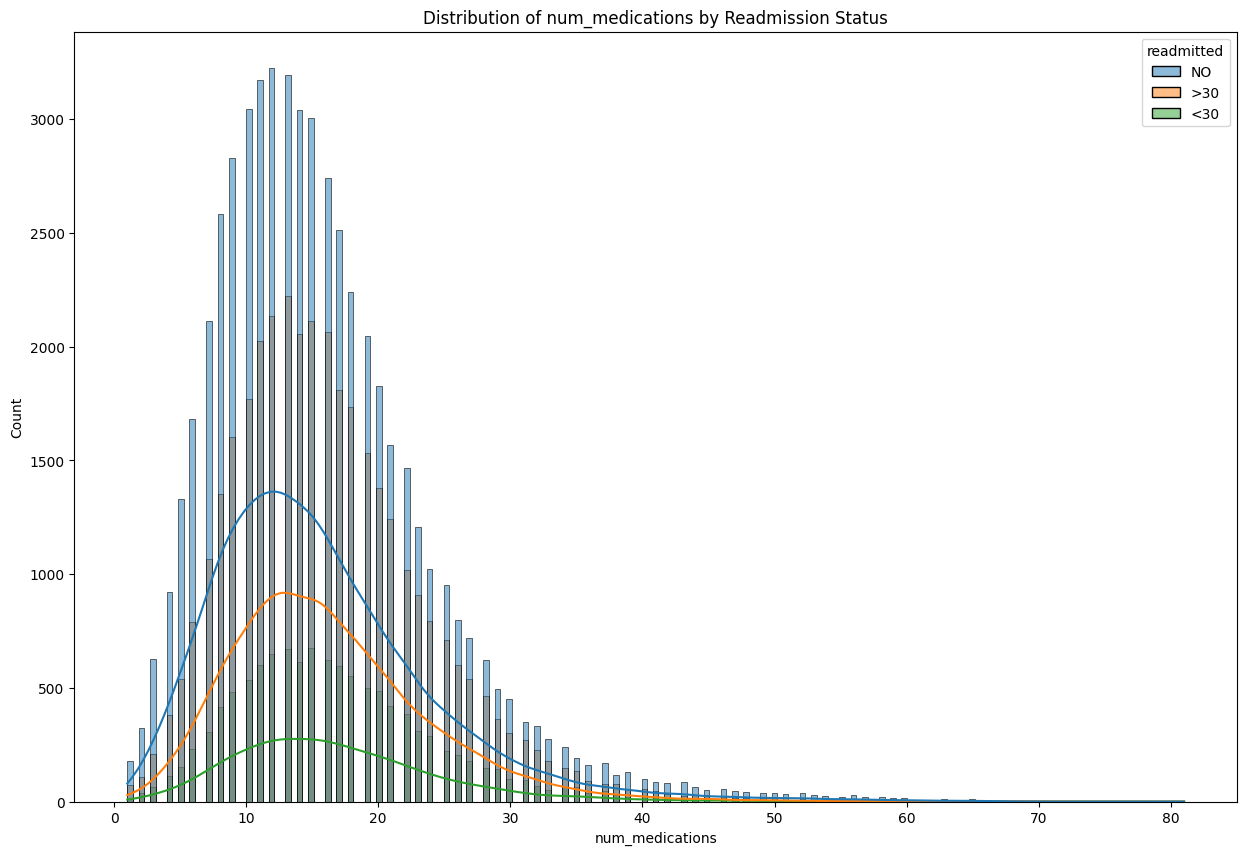

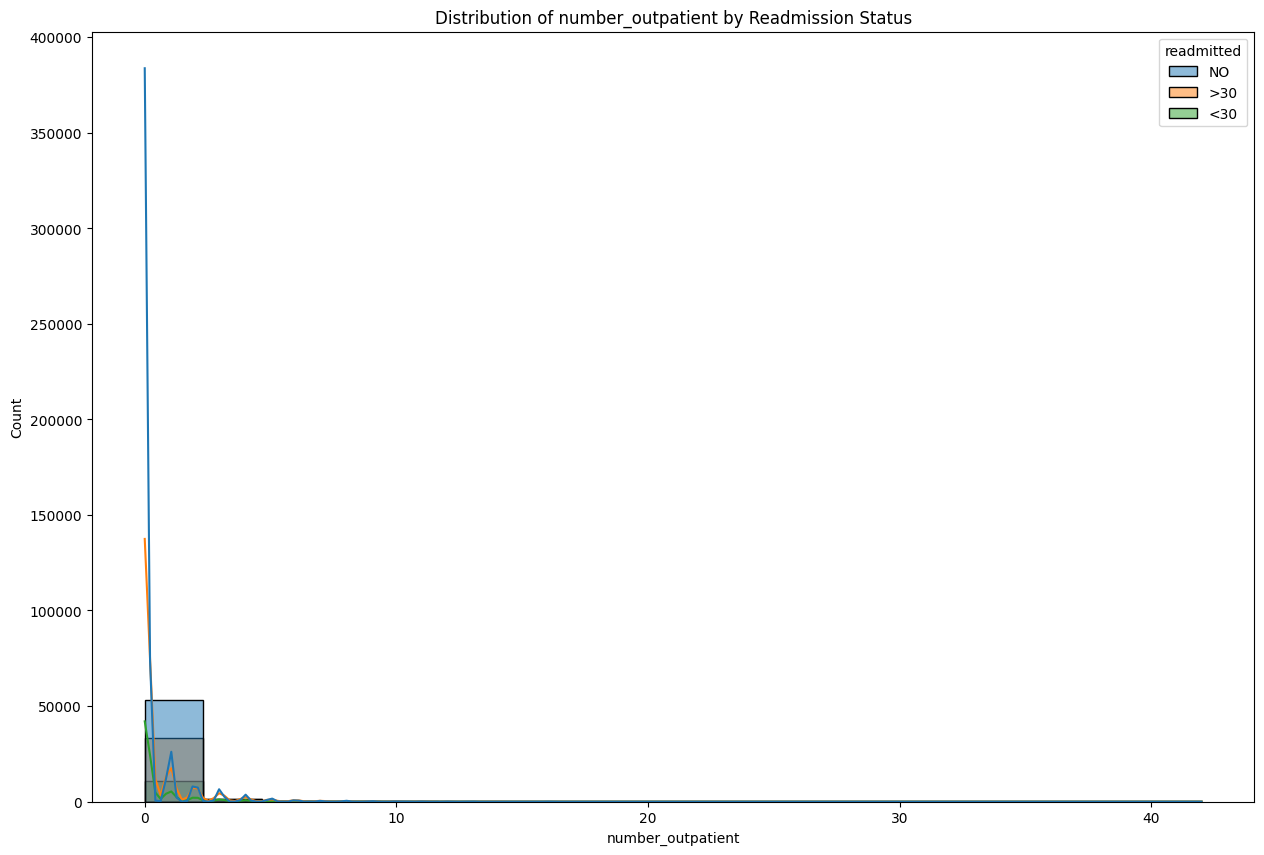

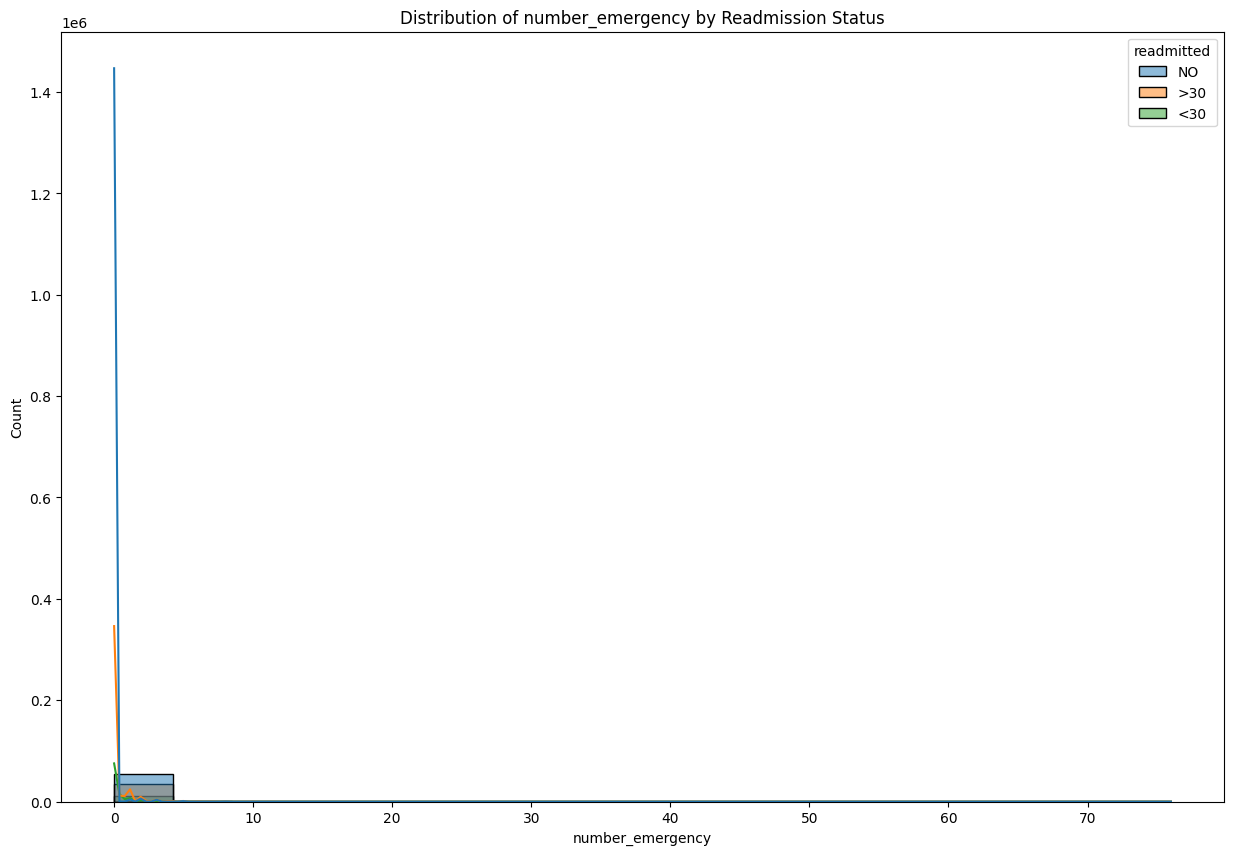

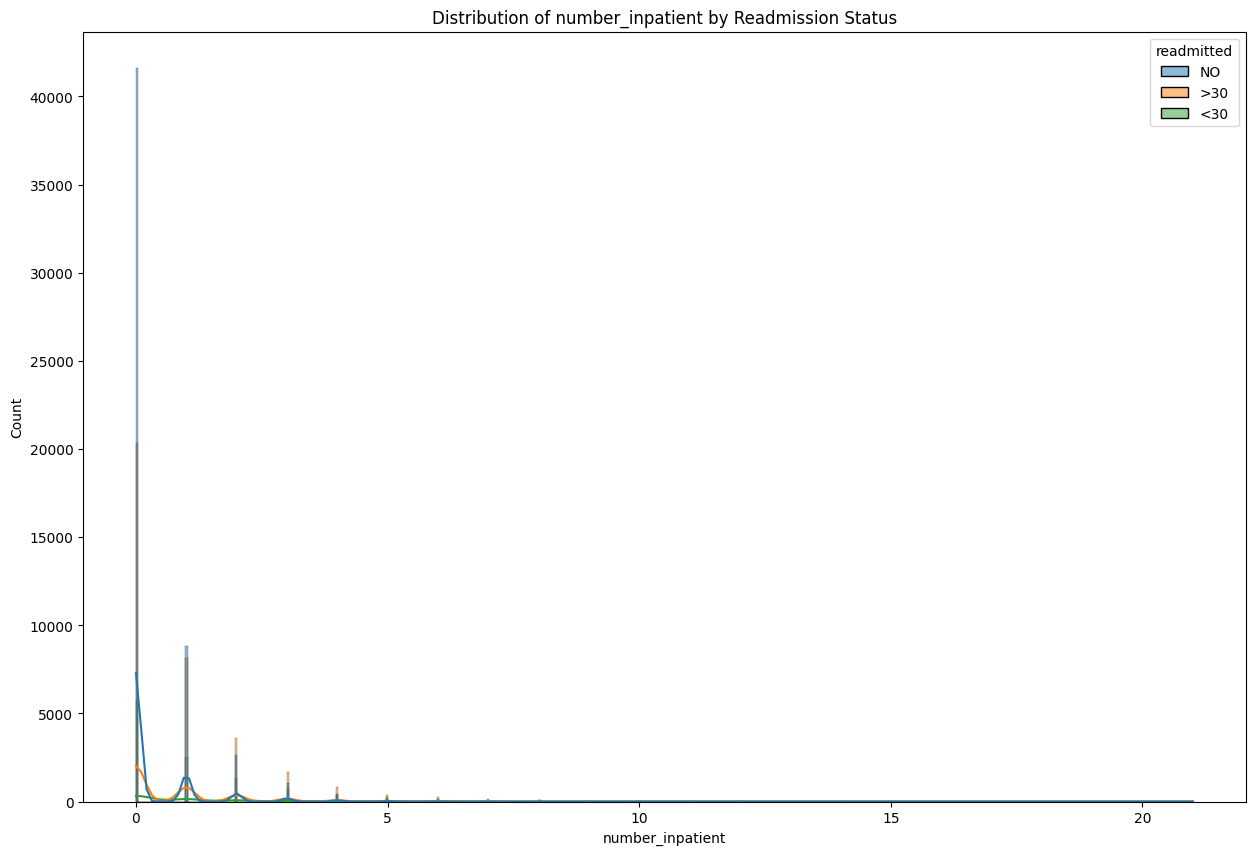

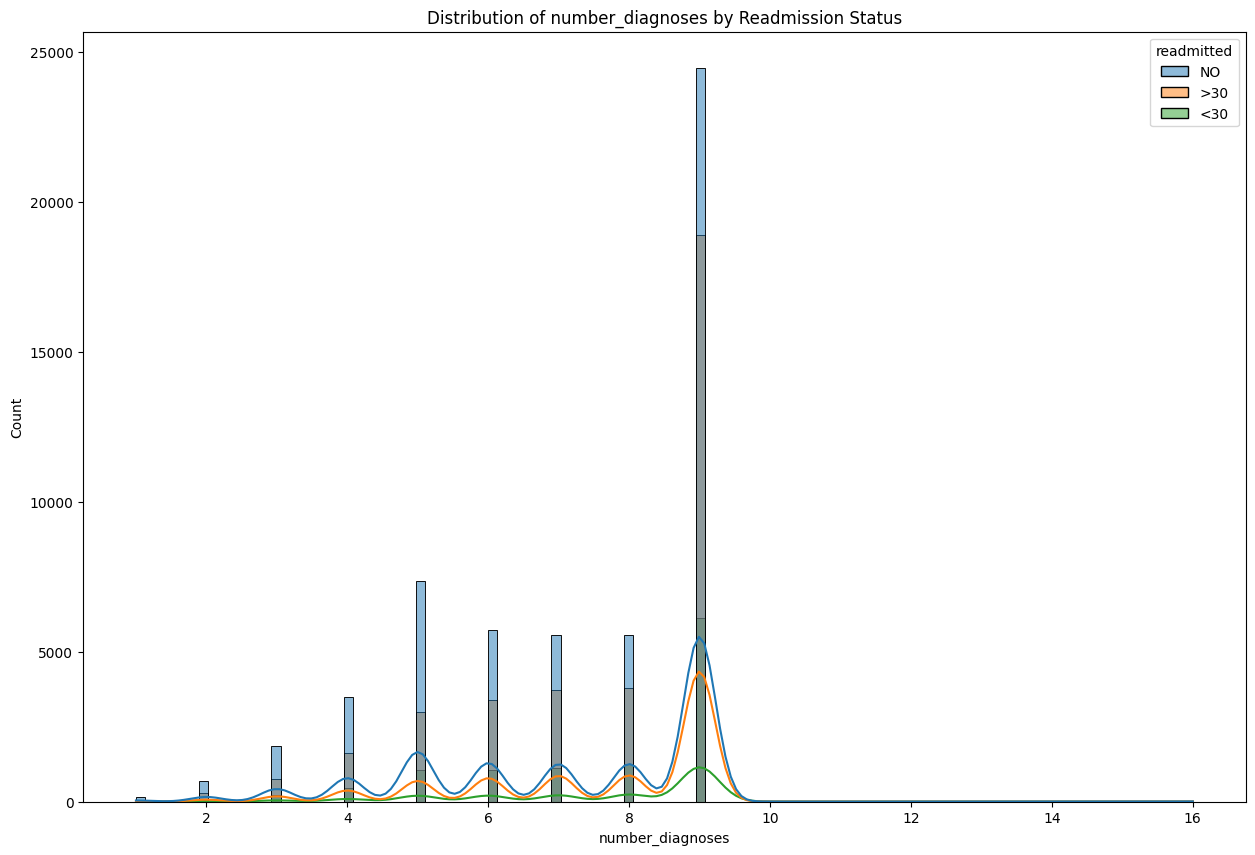

In [4]:
# Seperate out features for visualization
num_features = patient_data.select_dtypes(include='number')
# Irrelevant or categoricall
num_features.drop(['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)

# Look at numerical feature distributions
for i, col in enumerate(num_features):
    plt.figure(figsize=(15, 10))
    sns.histplot(data=patient_data, x=col, hue='readmitted', kde=True)
    plt.title(f'Distribution of {col} by Readmission Status')

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


<Figure size 1500x1000 with 0 Axes>

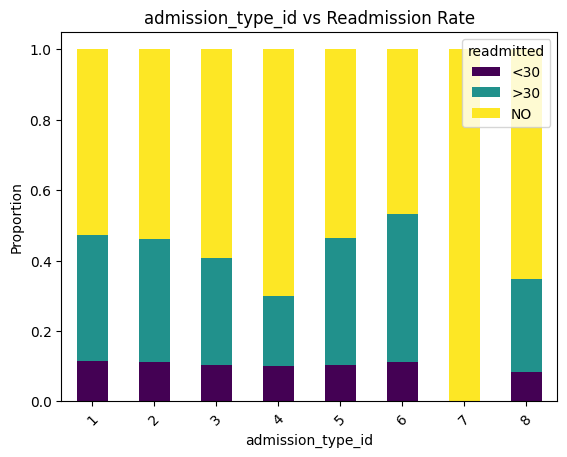

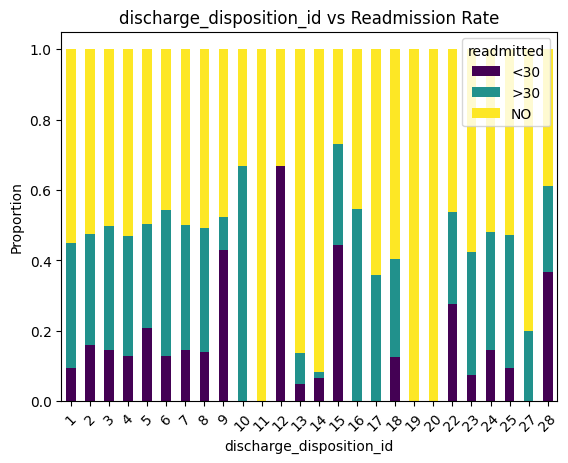

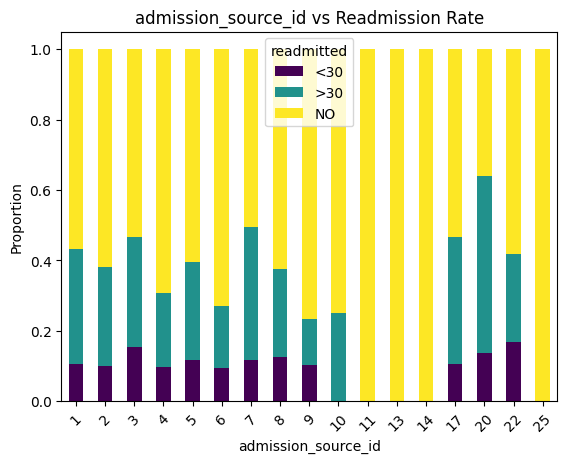

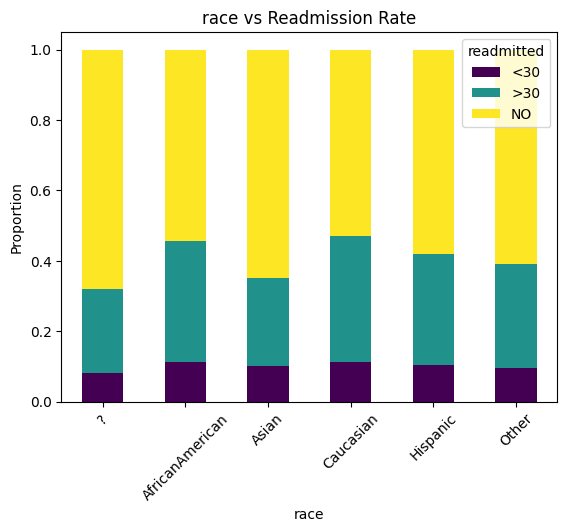

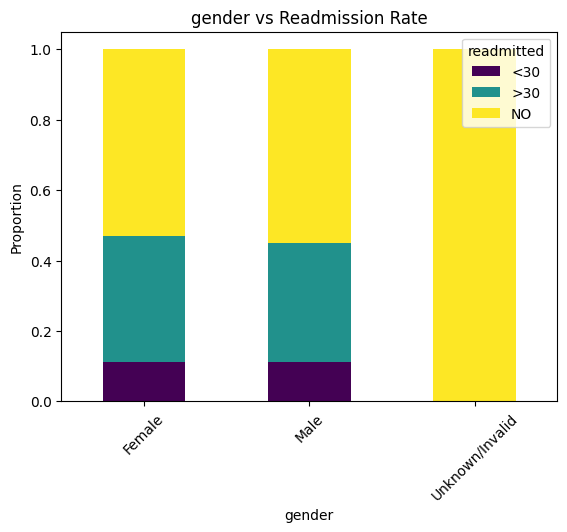

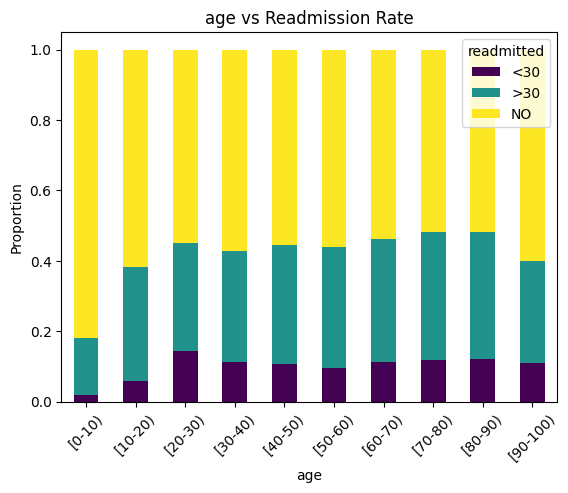

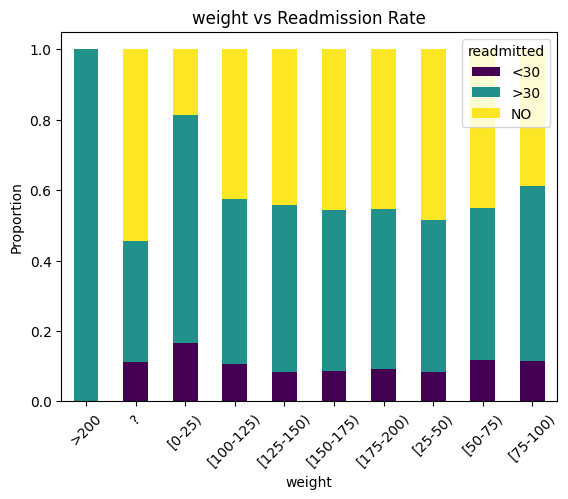

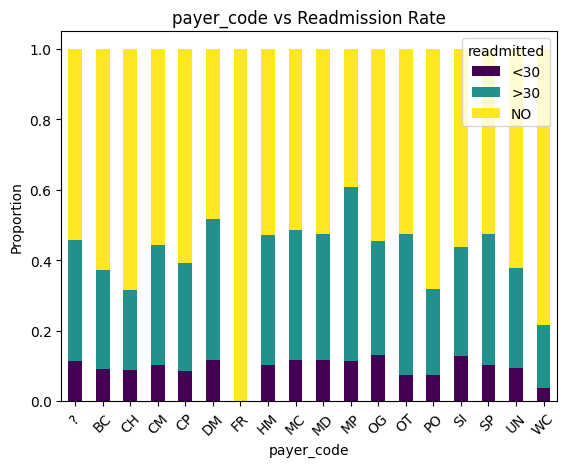

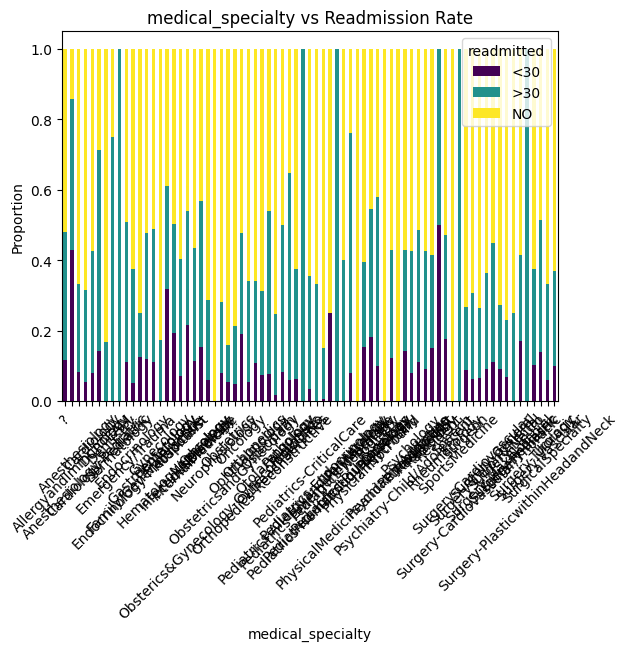

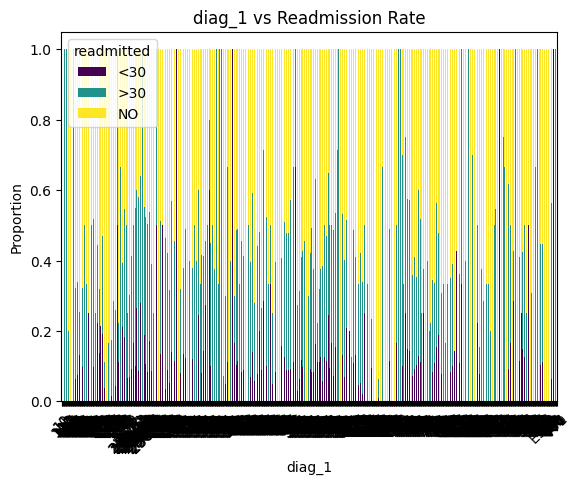

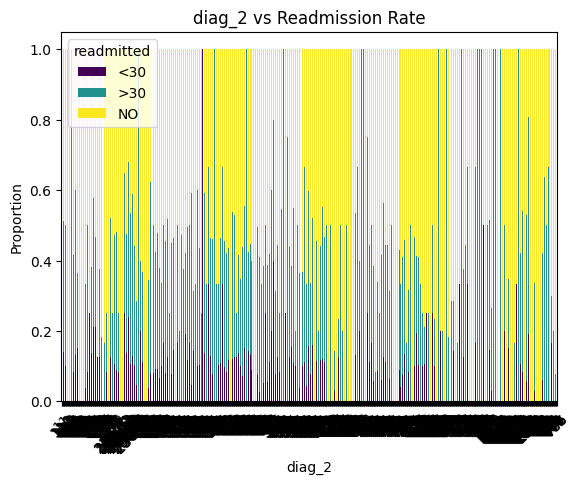

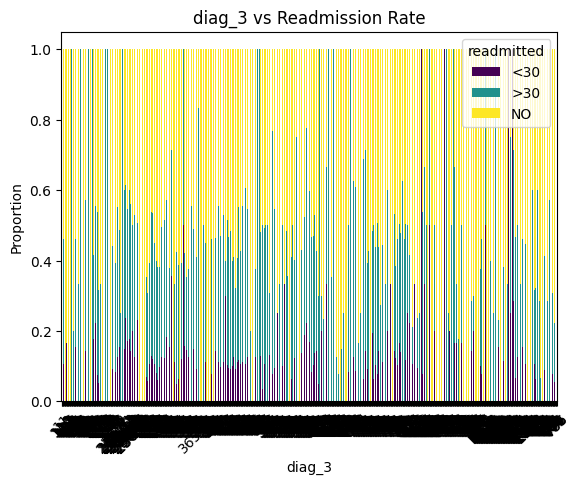

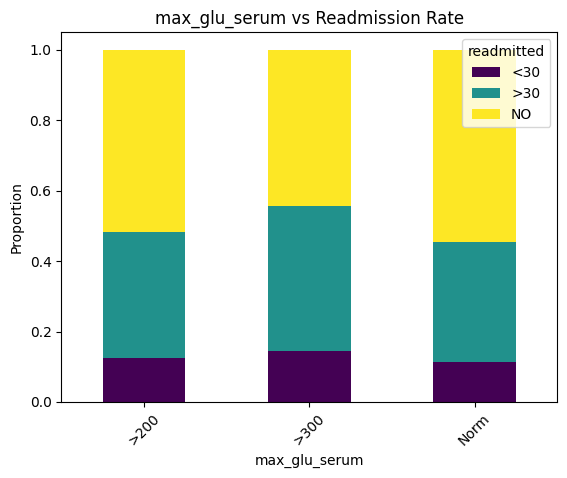

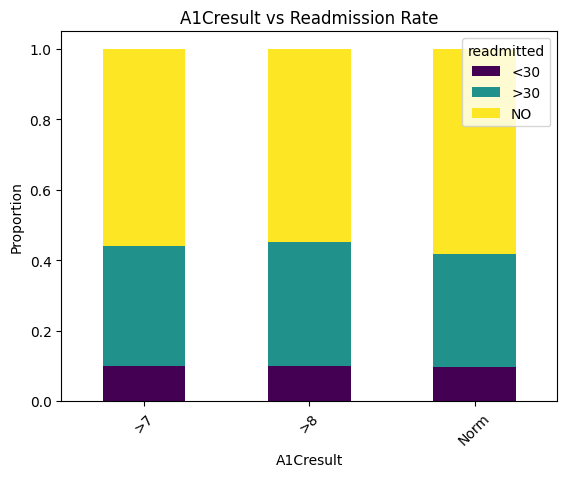

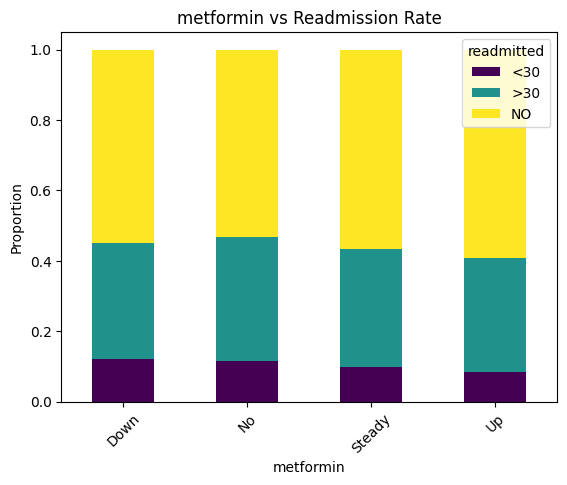

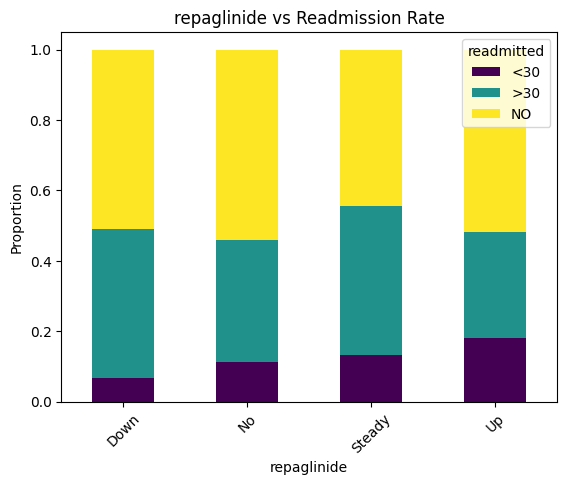

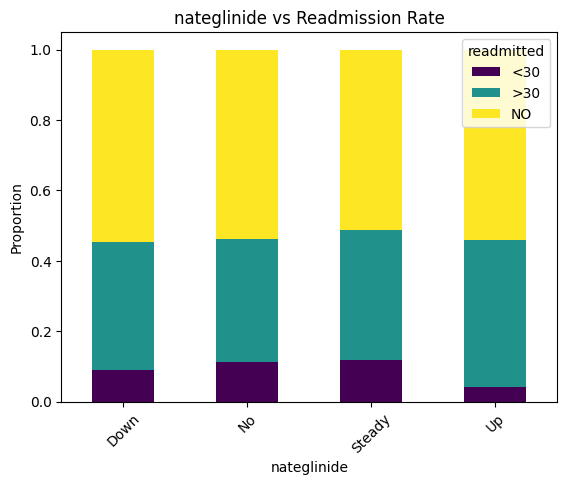

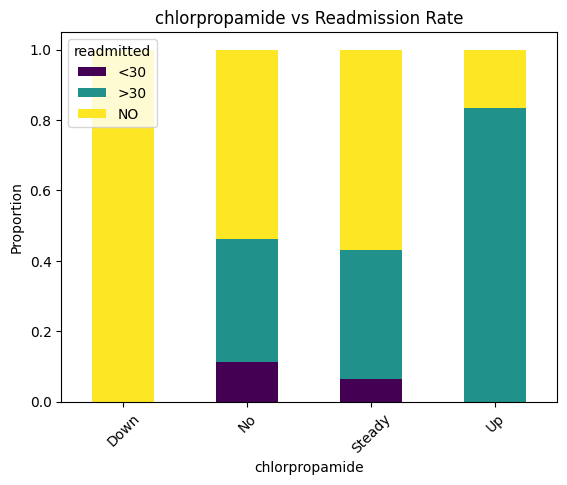

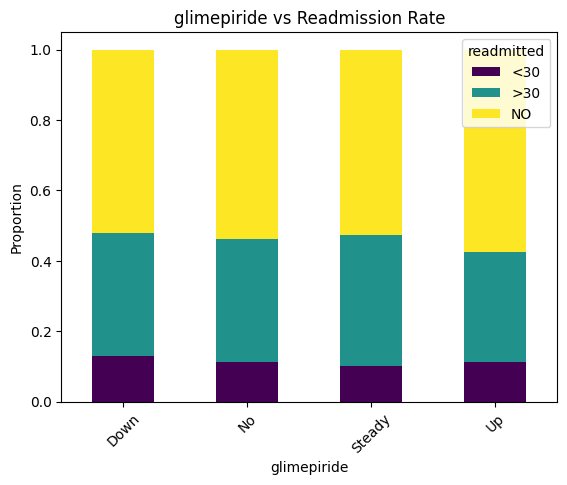

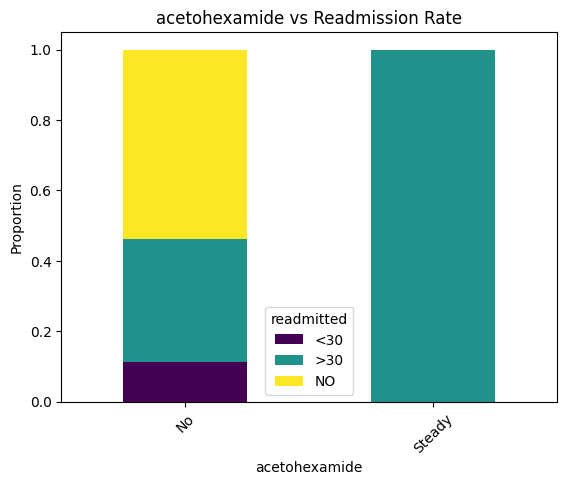

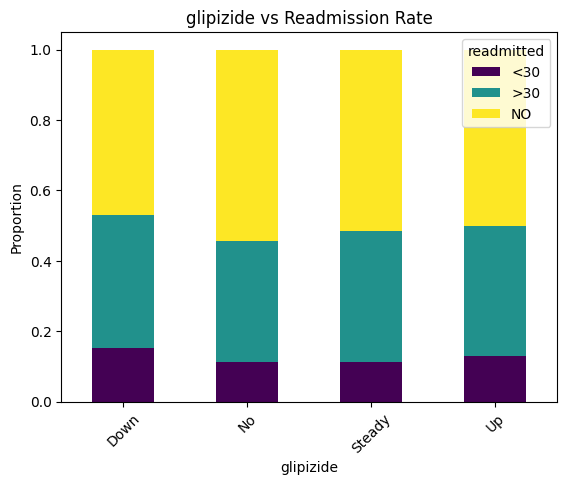

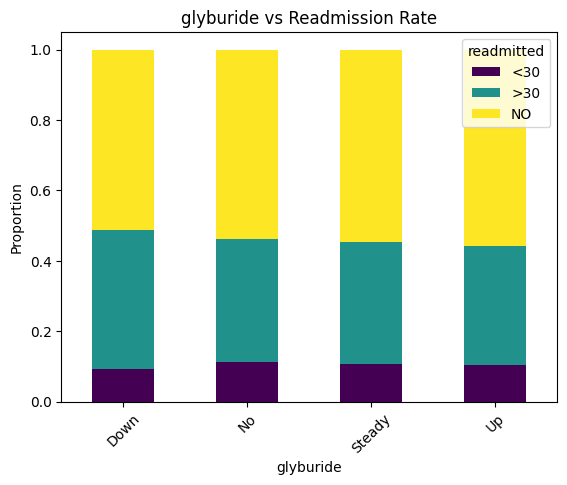

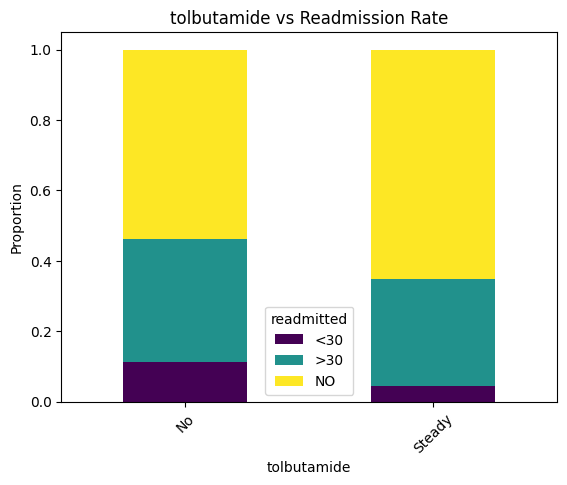

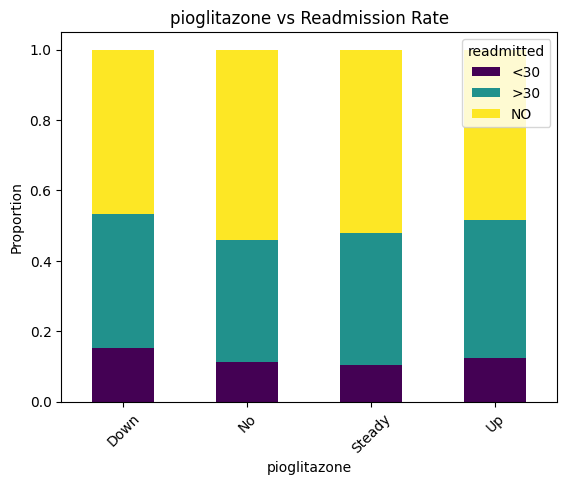

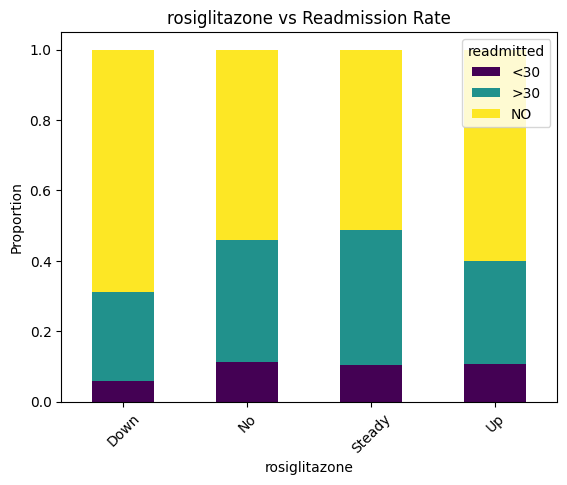

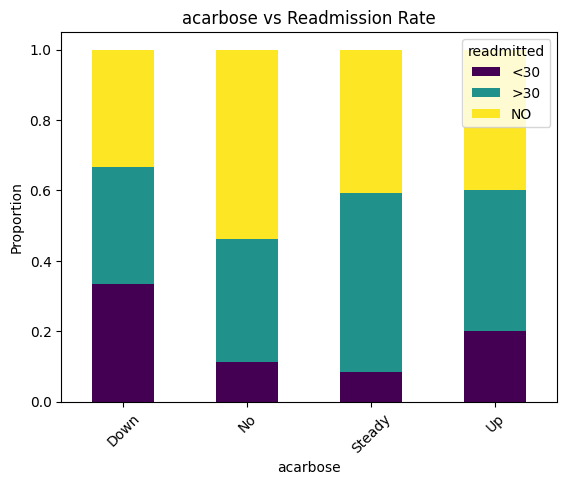

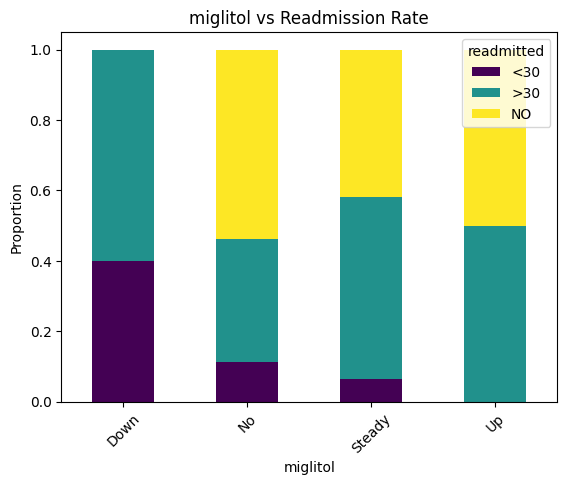

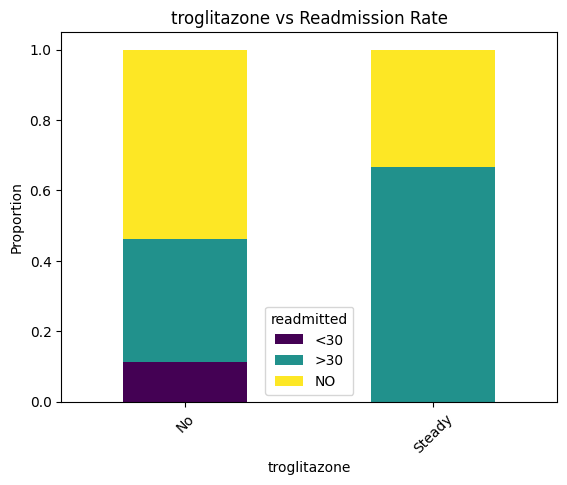

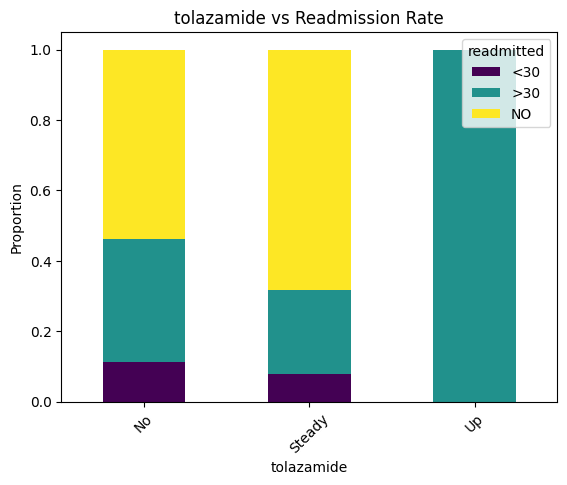

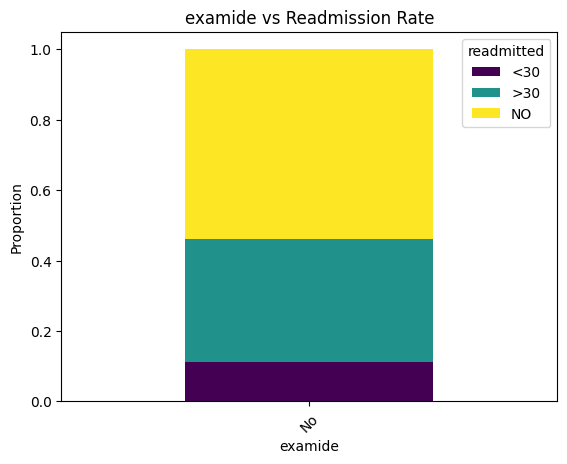

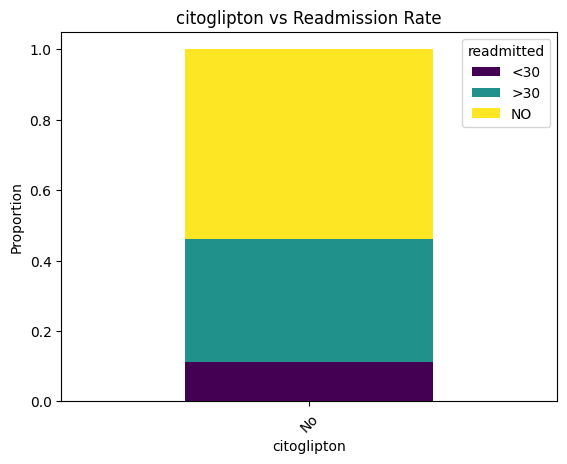

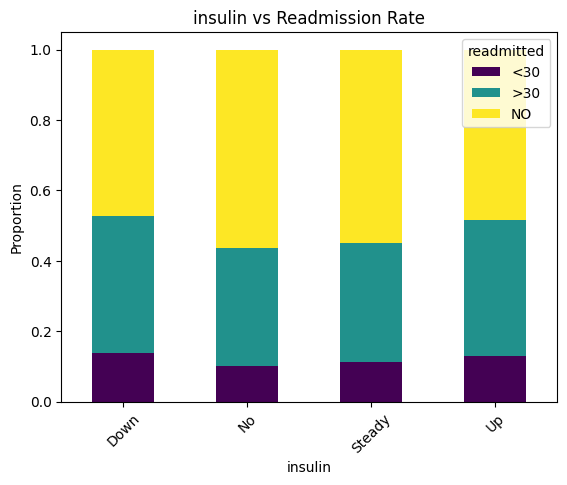

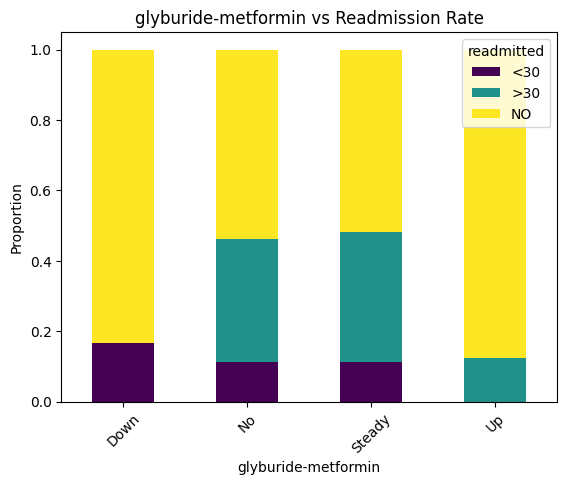

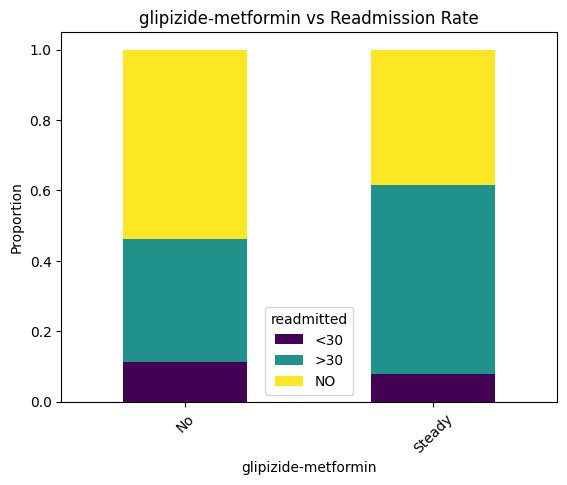

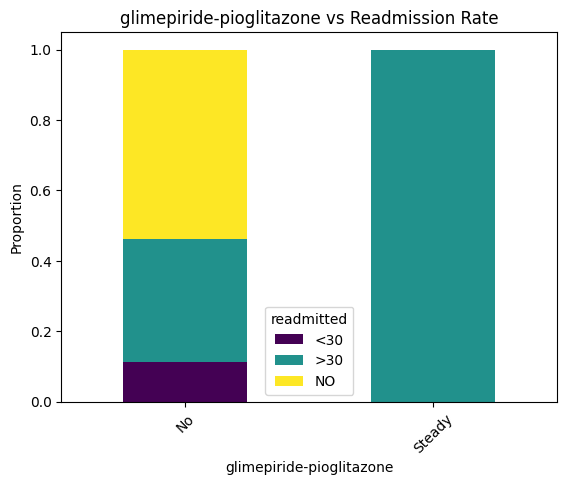

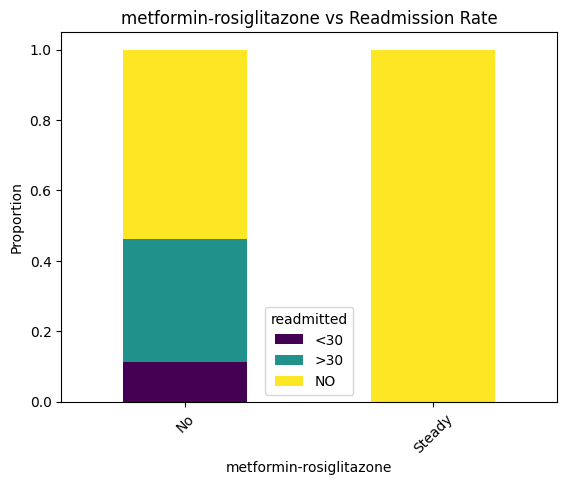

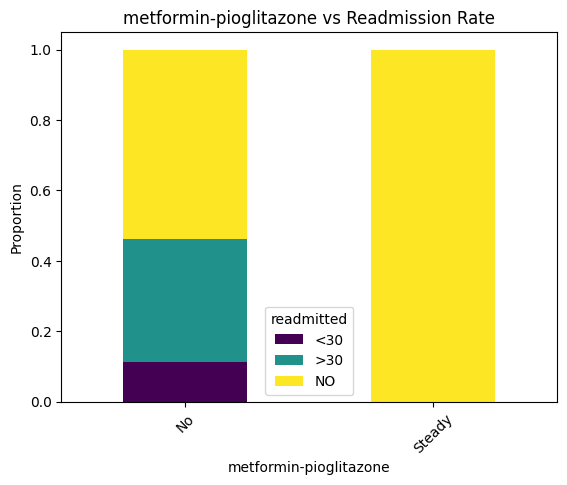

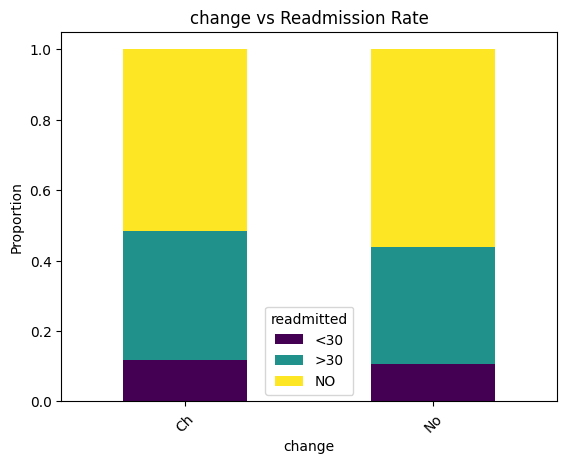

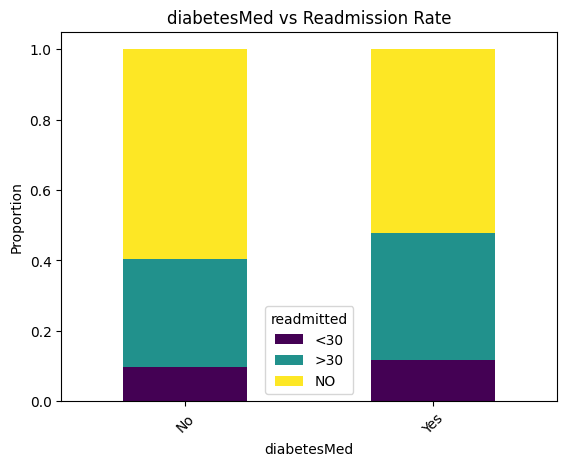

In [5]:
# Seperate out features for visualization
categorical = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
cat_columns = patient_data.select_dtypes(include='object')
cat_cols = list(cat_columns.columns)
categorical.extend(cat_cols)
categorical.remove('readmitted')
cat_features = patient_data[categorical]

# Categorical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_features):
    crosstab = pd.crosstab(patient_data[col], patient_data['readmitted'], normalize='index')
    crosstab.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'{col} vs Readmission Rate')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)

### Visualization Analysis

Those visualizations were so useful and informative, I feel like I just went to med school! Give me something to diagnose.

## Part 2: Implement Baseline Model
First you need to prepare the data for modeling



In [9]:
# Prepare data for modeling
# We will look to combine readmission to make this binary
# Creating a map to provide idempotency 
# If the former mapping gets rerun it causes problems
idempotent_mapping = {'<30': 1, '>30': 1, 'NO': 0, 0:0, 1:1}
patient_data['readmitted'] = patient_data['readmitted'].map(idempotent_mapping)

# These columns hold no meaning are just unique identifiers and readmitted is our target
cols_to_drop = ['encounter_id', 'patient_nbr', 'readmitted']
X = patient_data.drop(columns=cols_to_drop)
y = patient_data['readmitted']

# Split data into train, validation, and test sets
from sklearn.model_selection import train_test_split # Unclear why this wasn't in imports

# First split: 80% train+validation, 20% test
# Stratification added
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 75% train, 25% validation (resulting in 60% train, 20% validation, 20% test overall)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [10]:
# Run this cell without changes
# Preprocess data with Column Transformer pipeline
# To prevent high dimenstionality we will target encode the diagnosis codes rather than one hot encode
target_encode_cols = ['diag_1', 'diag_2', 'diag_3']
ohe_cols = [col for col in categorical if col not in target_encode_cols]
num_cols = num_features.columns

# Create the preprocessing function
num_pipe = Pipeline(steps=[('impute_num', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

ohe_pipe = Pipeline(steps=[('impute_cat', SimpleImputer(strategy='constant', fill_value='?')),
                           ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

tarenc_pipe = Pipeline(steps=[('impute_cat', SimpleImputer(strategy='constant', fill_value='?')),
                              ('tar_encode', TargetEncoder(target_type='binary'))])

col_trans = ColumnTransformer(transformers=[('num', num_pipe, num_cols),
                                            ('cat', ohe_pipe, ohe_cols),
                                            ('tar', tarenc_pipe, target_encode_cols)],
                              remainder='passthrough')

# Need to provide y_train for the target encoder
X_train_pro = col_trans.fit_transform(X_train, y_train)
X_val_pro = col_trans.transform(X_val)
X_test_pro = col_trans.transform(X_test)

print(f"Training set: {X_train_pro.shape} samples")
print(f"Validation set: {X_val_pro.shape} samples")
print(f"Test set: {X_test_pro.shape} samples")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 8, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [8, 25, 33] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Training set: (61059, 220) samples
Validation set: (20353, 220) samples
Test set: (20354, 220) samples


In [11]:
# Create a baseline with two hidden layers, use the relu activation function, select an appropriate number of nodes (64, 32)
# Don't forget your output layer for binary classification
def create_baseline_model(input_dim):
    model = Sequential([
        # Hidden layers
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        # Output layer for binary classification
        Dense(1, activation='sigmoid') 
    ])

    model.compile(
        # Use Adam
        optimizer=tf.keras.optimizers.Adam(),
        # Select appropriate loss for binary classification
        loss='binary_crossentropy',
        # Evaluate based on recall
        metrics=['recall']
    )

    return model

# Create and train the baseline model
baseline_model = create_baseline_model(X_train_pro.shape[1])
baseline_model.summary()

# Train the model without any callbacks
baseline_history = baseline_model.fit(
    X_train_pro, y_train,
    epochs=50,  # Train for a fixed number of epochs
    batch_size=32,
    validation_data=(X_val_pro, y_val),
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,257 (63.50 KB)

 Trainable params: 16,257 (63.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.6467 - recall: 0.4688 - val_loss: 0.6224 - val_recall: 0.5837
Epoch 2/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6219 - recall: 0.5671 - val_loss: 0.6190 - val_recall: 0.5836
Epoch 3/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6153 - recall: 0.5759 - val_loss: 0.6178 - val_recall: 0.5913
Epoch 4/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6110 - recall: 0.5883 - val_loss: 0.6186 - val_recall: 0.5995
Epoch 5/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6071 - recall: 0.5917 - val_loss: 0.6199 - val_recall: 0.5982
Epoch 6/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6032 - recall: 0.5989 - val_loss: 0.6223 - val_recall: 0.6142
Epoch 7/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5993 - recall: 0.6046 - val_loss: 0.6240 - val_recall: 0.6190
Epoch 8/50
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5957 - recall: 0.6078 - val_loss: 0.6280 - val_recall:

## Part 3: Visualize Training and Validation curves
Important to visualize our training curves in order to understand model limitations and adapt the next iteration. Particularly important to understand the models bias and variance (over/under fitting).

Baseline Test Recall: 0.5503


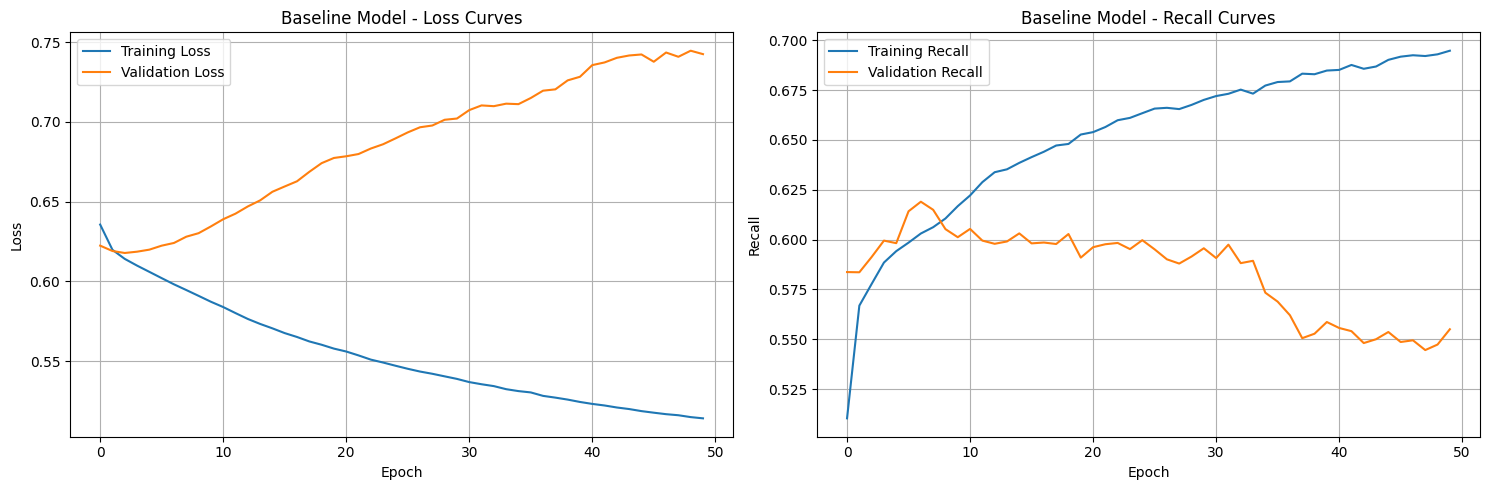

In [13]:
# Evaluate the baseline model on testing data
baseline_test_loss, baseline_test_recall = baseline_model.evaluate(X_test_pro, y_test, verbose=0)
print(f"Baseline Test Recall: {baseline_test_recall:.4f}")

# Plot the training and validation loss/accuracy curves
def plot_training_history(history, title=''):
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title(f'{title} - Recall Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot baseline model training history
plot_training_history(baseline_history, title='Baseline Model')

#### Commentary

We've got a serious case of the overfits here. However, note the "zoomed in" y scale. The changes over epochs are informative and important of course, but not as extreme as they might appear.

## Part 4: Implement Callbacks for Monitoring and Early Stopping

Clear sign of model overfitting and gradient problems. Now, let's implement callbacks to monitor training and prevent overfitting. We will also provide a more complex network to attempt to address the overfitting.

In [16]:
# Implement EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Implement ModelCheckpoint callback to save the best model
checkpoint_filepath = './best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_recall',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Implement TensorBoard callback for visualization
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

# Don't change this one
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,        # Reduce learning rate by 80%
    patience=3,        # Wait 5 epochs of no improvement
    min_lr=0.000001,    # Don't go below this learning rate
    verbose=1          # Print when learning rate changes
)

# Combine all callbacks into a list
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback,
    reduce_lr
]

In [17]:
# Run this cell without changes
# Create an improved model with gradient problem mitigation strategies and train with callbacks
def create_improved_model(input_dim):
    model = Sequential()
    
    # First layer
    model.add(Input((input_dim,)))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))  
    
    # Second layer
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Use Adam optimizer with gradient clipping
    optimizer = Adam(learning_rate=0.001, clipvalue=.5)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['recall']
    )
    
    return model

# Create and compile the improved model
improved_model = create_improved_model(X_train_pro.shape[1])
improved_model.summary()

# Train the improved model with the callbacks
improved_history = improved_model.fit(
    X_train_pro, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_pro, y_val),
    callbacks=callbacks,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        14,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,449 (64.25 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
1891/1909 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6746 - recall: 0.5354
Epoch 1: val_recall improved from -inf to 0.40917, saving model to ./best_model.keras
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6744 - recall: 0.5353 - val_loss: 0.6274 - val_recall: 0.4092 - learning_rate: 0.0010
Epoch 2/100
1898/1909 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6309 - recall: 0.5397
Epoch 2: val_recall did not improve from 0.40917
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6309 - recall: 0.5397 - val_loss: 0.6272 - val_recall: 0.4047 - learning_rate: 0.0010
Epoch 3/100
1896/1909 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6261 - recall: 0.5541
Epoch 3: val_recall improved from 0.40917 to 0.40991, saving model to ./best_model.keras
1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6260 - recall: 0.5541 - val_loss: 0.6252 - val_recall: 0.4099 - learning_rate: 0.0010
Epoch 4/100
1892/1909 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6242 - recall: 0.5547
Epoch 4: va

## Part 5: Analyze Training Results
Again, it is always important to look at curves. Here we should see way less overfitting and platued losses which tell us the model has gone about as far as it can go with the data at hand.

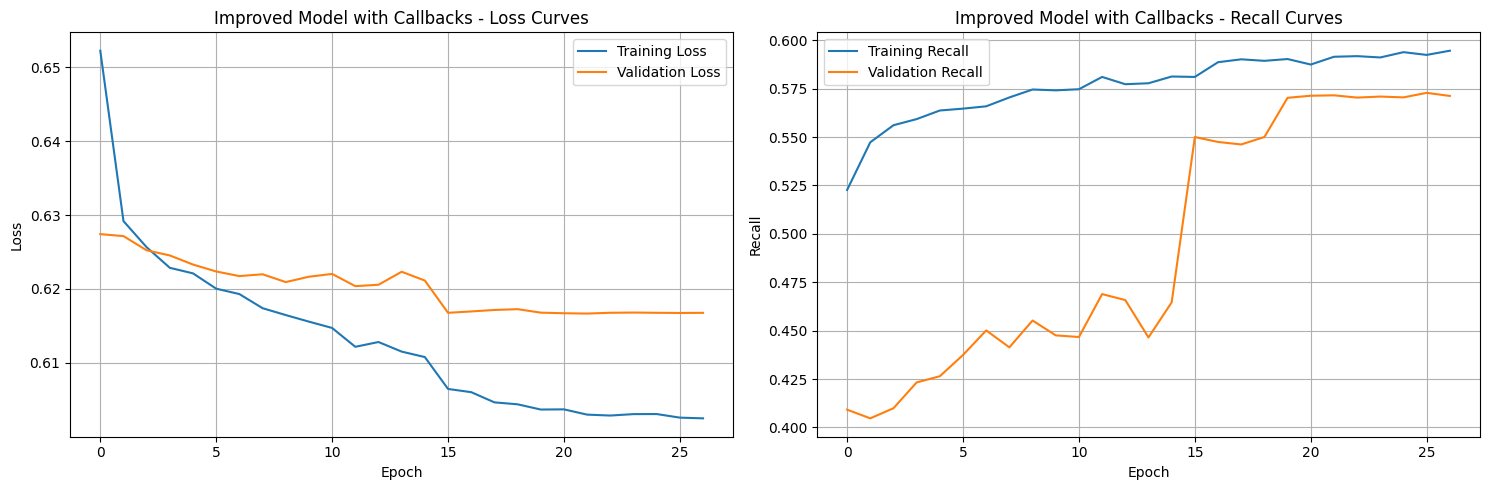

Improved Model (Final) Test Recall: 0.5671
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - loss: 0.6213 - recall: 0.5582
Best Model (Checkpoint) Test Recall: 0.5671
Baseline Test Recall: 0.5503
Early Stopping activated at epoch 27 of 100


In [18]:
# Plot the training history with early stopping
plot_training_history(improved_history, title='Improved Model with Callbacks')

# Load the best model saved by ModelCheckpoint
best_model = tf.keras.models.load_model('./best_model.keras')

# Evaluate the final improved model
improved_test_loss, improved_test_recall = best_model.evaluate(X_test_pro, y_test, verbose=0)
print(f"Improved Model (Final) Test Recall: {improved_test_recall:.4f}")

# Evaluate the best model (saved by checkpoint)
best_test_loss, best_test_recall = best_model.evaluate(X_test_pro, y_test, verbose=1)
print(f"Best Model (Checkpoint) Test Recall: {best_test_recall:.4f}")

# Compare with baseline
print(f"Baseline Test Recall: {baseline_test_recall:.4f}")
print(f"Early Stopping activated at epoch {len(improved_history.history['loss'])} of 100")

In [19]:
# Load TensorBoard extension
%load_ext tensorboard

# Launch TensorBoard
%tensorboard --logdir=logs/fit

# Note: TensorBoard output will appear in the notebook
# We can examine histograms of weights and gradients, model graph,
# and other useful visualizations

When training complex machine learning models, the relationship between model complexity and data quality is crucial. Even the most sophisticated neural network architecture can plateau if the loss stops decreasing, indicating that the model has reached the limits of what it can learn from the available data. At this point, rather than adding more layers or parameters, the focus should shift to improving data quality, diversity, and relevance to the specific task. Better data—whether that means more accurate labels, more representative samples, or enhanced feature engineering—often proves more valuable than increased model complexity for breaking through performance plateaus.

## Part 6: Reflection and Documentation

### Question 1: How did early stopping affect the training process and final model performance?

Early stopping serves two purposes - first, in saving computational resources, and second in preventing overfitting (discussed further in Question 3). The data set we used only contains around 100,000 records, making it manageable on a local machine. If we were to extend this to data from many hospitals over many years, we could easily have tens of millions of records. Computational resource concerns were also highlighted as part of our project requirements.

### Question 2: What patterns did you observe in the training and validation curves?

In the original model:
 * Loss
   * Training steadily decreases
   * Validation almost continually increases
   * -> Classic overfitting
 * Recall
   * Training steadily increases
   * There is more "noise" in validation recall - spikes around epoch 6
   * Substantial downward trend after epoch 30
   * -> Again, overfitting

Improved model:
 * Loss
   * Both training and validation show a strong downward trend
   * A slight upward blip around epoch 12, with a plateau in validation at epoch 15
   * -> The model has reached a generalization limit
   * -> It's not getting worse, but gets no better either
 * Recall
   * More "noise" here
   * Sharp upward tick in validation around epoch 15, further gain at 18
   * -> Again, plateau indicates the model has learned what it can

### Question 3: In a healthcare context like this one, why is it particularly important to prevent overfitting?

Conversely, incorrectly flagging a patient as likely to be re-admitted could lead to wasting healthcare professionals' time and resources on patients that are not as comparatively in need of additional attention. Bad predictions caused by overfitting would lead to model abandonment (wasting development time) or worse patient outcomes.

### Question 4: How would you explain the benefits of your monitoring approach to non-technical healthcare staff?

"Imagine two students studying for a test. One student has the answer sheet and simply memorizes the test answers, but develops little if any deep understanding of the topic. Another works through written material, problems, and exercises, checking their understanding as they go. While the first student might perform better on the specific test questions, the second student has a better understanding that they will be able to apply to future problems.

Our monitoring system is designed to ensure that the model behaves more like the second student, so that it can make accurate predictions for future patients."

### Final Note

While we've solved the overfitting problem that was apparent with the original model, it's important to keep the overall context in mind. With only two relatively balanced classes, a recall score of 57% is barely better than a coin flip. This model would require substantial additional work to be of any practical use.

## Summary of Implemented Techniques

In this lab, we've implemented and demonstrated several key techniques for improving neural network training:

1. **Early Stopping**: Automatically halts training when validation performance stops improving, preventing overfitting and saving computational resources.

2. **Model Checkpointing**: Saves the best-performing model during training, ensuring we retain the optimal weights even if training continues past the ideal point.

3. **Training Visualization**: Using TensorBoard and custom plotting functions to monitor and interpret the training process in real-time.

4. **BatchNormalization**: Stabilizes the distribution of layer inputs during training, helping to prevent vanishing/exploding gradients.

5. **Gradient Clipping**: Limits the size of gradient updates to prevent unstable training.

6. **Advanced Activation Functions**: Using LeakyReLU instead of standard ReLU to prevent "dead neurons" and improve gradient flow.

8. **Dropout**: Randomly deactivating neurons during training to prevent overfitting and improve generalization.

By combining these techniques, we were able to improve model performance and training stability if only minorly, resulting in a more reliable patient readmission prediction model that would perform better in real-world healthcare settings. Ultimately, because our final model is accounting for potential issues and still not performing as well as we hoped, it becomes a matter of needing better and more data to predict readmission.

These monitoring and optimization techniques are applicable across a wide range of deep learning applications, not just healthcare, and should be considered essential components of any robust deep learning workflow.